In [1]:
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D,\
    UpSampling2D, Dropout, Activation, Flatten, Reshape, merge, Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.datasets import mnist
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, RMSprop
from keras.initializers import Initializer, RandomNormal
from keras.regularizers import l2
from keras.models import Model
from PIL import Image
import scipy.misc
import matplotlib.pyplot as plt
from scipy.misc import imsave
import bcolz
import random

Using TensorFlow backend.


In [2]:
'''Note that in the paper, the output of the generative model
is tanh activation layer, which will be the input to our
discriminative model. So we need to normalize input images 
to tanh scale (-1.0 to 1.0)'''

x_train = bcolz.open('data/x_train.bc')[:]
x_train = (x_train.astype(np.float32)/255.0) * 2.0 - 1.0

In [3]:
'''Discriminator network'''
discriminator_input = Input(x_train.shape[1:])
discriminator_x = Conv2D(256, (5,5), strides=(2, 2), padding = 'same',
          kernel_regularizer = l2(0.0001))(discriminator_input)
discriminator_x = LeakyReLU(0.2)(discriminator_x)
discriminator_x = Dropout(0.5)(discriminator_x)

discriminator_x = Conv2D(512, (5,5), strides=(2, 2), padding = 'same',
          kernel_regularizer = l2(0.0001))(discriminator_x)
discriminator_x = LeakyReLU(0.2)(discriminator_x)
discriminator_x = Dropout(0.5)(discriminator_x)

discriminator_x = Flatten()(discriminator_x)
discriminator_x = Dense(256, kernel_regularizer = l2(0.0001))(discriminator_x)
discriminator_x = LeakyReLU(0.2)(discriminator_x)
discriminator_x = Dropout(0.5)(discriminator_x)

discriminator_x = Dense(1,activation='sigmoid')(discriminator_x)

discriminator_model = Model(discriminator_input,discriminator_x)
discriminator_model.compile(Adam(0.00001),loss='binary_crossentropy')

In [4]:
'''Generator network'''
generator_input = Input((100,))
generator_x = Dense(512*7*7, kernel_initializer=RandomNormal(
                                   mean=0.0, stddev=0.02))(generator_input)
generator_x = BatchNormalization()(generator_x)
generator_x = Activation('relu')(generator_x)
generator_x = Reshape((7,7,512))(generator_x)
generator_x = UpSampling2D()(generator_x)

generator_x = Conv2D(256, (3,3), padding='same', 
                  kernel_initializer=RandomNormal(
                                   mean=0.0, stddev=0.02))(generator_x)
generator_x = BatchNormalization()(generator_x)
generator_x = Activation('relu')(generator_x)
generator_x = UpSampling2D()(generator_x)

generator_x = Conv2D(128, (3,3), padding='same', 
                  kernel_initializer=RandomNormal(
                                   mean=0.0, stddev=0.02))(generator_x)
generator_x = BatchNormalization()(generator_x)
generator_x = Activation('relu')(generator_x)
generator_x = UpSampling2D()(generator_x)

generator_x = Conv2D(64, (3,3), padding='same', 
                  kernel_initializer=RandomNormal(
                                   mean=0.0, stddev=0.02))(generator_x)
generator_x = BatchNormalization()(generator_x)
generator_x = Activation('relu')(generator_x)
generator_x = UpSampling2D()(generator_x)

generator_x = Conv2D(32, (3,3), padding='same',
                  kernel_initializer=RandomNormal(
                                   mean=0.0, stddev=0.02))(generator_x)
generator_x = BatchNormalization()(generator_x)
generator_x = Activation('relu')(generator_x)

generator_x = Conv2D(16, (3,3), padding='same',
                  kernel_initializer=RandomNormal(
                                   mean=0.0, stddev=0.02))(generator_x)
generator_x = BatchNormalization()(generator_x)
generator_x = Activation('relu')(generator_x)

generator_x = Conv2D(3, (1,1), padding='same',
                  kernel_initializer=RandomNormal(
                                   mean=0.0, stddev=0.02))(generator_x)
generator_x = Activation('tanh')(generator_x)

generator_model = Model(generator_input,generator_x)
generator_model.compile(Adam(0.00001),loss='binary_crossentropy')

In [5]:
'''Freeze discriminator'''
discriminator_model.trainable = False
for layer in discriminator_model.layers:
    layer.trainable = False

'''GAN = generator + discriminator'''
gan_input = Input((100,))
gan_x = generator_model(gan_input)
gan_x = discriminator_model(gan_x)
model = Model(gan_input, gan_x)
model.compile(Adam(0.00001), loss = "binary_crossentropy")

In [ ]:
'''Train discriminator for 1 epoch as a start'''
init_data = len(x_train)//2

real = np.random.permutation(x_train)[:init_data]
fake = generator_model.predict(np.random.rand(init_data,100))
x_init = np.concatenate((real,fake))

real_label = np.zeros((init_data,1))
fake_label = np.ones((init_data,1))
y_init = np.concatenate((real_label,fake_label))

In [ ]:
'''Unfreeze discriminator'''
discriminator_model.trainable = True
for layer in discriminator_model.layers:
    layer.trainable = True

discriminator_model.fit(x_init,y_init,batch_size=64,epochs=1)

In [ ]:
discriminator_loss = []
generator_loss = []
num_data = len(x_train)

In [ ]:
'''Note that our discriminator and generator models are referenced
by our GAN and we do not want the discriminator part of the GAN to be
trained when trying to minimize generator losses. To do so, we can just
do it by freezing discriminator model before training the generator'''

model.optimizer = Adam(lr = 0.00001, beta_1 = 0.5, beta_2 = 0.99)
discriminator_model.optimizer = Adam(lr=0.00001, beta_1 = 0.5, beta_2 = 0.99)
generator_model.optimizer = Adam(lr=0.00001, beta_1 = 0.5, beta_2 = 0.99)

num_iterations = 50000
real_per_iter = 32
fake_per_iter = 32

real_label = np.zeros((real_per_iter,1))
fake_label = np.ones((fake_per_iter,1))
y_mini = np.concatenate((real_label,fake_label))

repeat_discriminator = 1
repeat_generator = 1

for i in range(num_iterations):
    print('Iteration #%d' % i)
    
    '''Unfreeze discriminator'''
    discriminator_model.trainable = True
    for layer in discriminator_model.layers:
        layer.trainable = True
        
    '''Training discriminator'''
    for k in range(repeat_discriminator):
        '''Create real and fake data, as well as their labels'''
        real = x_train[np.random.randint(0,high=num_data,size=real_per_iter)]
        fake = generator_model.predict(np.random.rand(fake_per_iter,100))
        x_mini = np.concatenate((real, fake))
        discriminator_loss.append(discriminator_model.train_on_batch(x_mini,y_mini))
    
    '''Freeze discriminator'''
    discriminator_model.trainable = False
    for layer in discriminator_model.layers:
        layer.trainable = False
    
    '''Training generator'''
    for k in range(repeat_generator):
        generator_x = np.random.rand(fake_per_iter*2,100)
        generator_y = np.zeros((fake_per_iter*2,1)) #we want it to be classified as real
        generator_loss.append(model.train_on_batch(generator_x, generator_y))
    
    '''Show losses'''
    print('Discriminator loss = %.6f Generator loss = %.6f'
          % (discriminator_loss[len(discriminator_loss)-1],
             generator_loss[len(generator_loss)-1]))

In [ ]:
'''Plot discriminator and generator losses'''
figure,axis = plt.subplots(1,2)
plt.tight_layout()
axis[0].plot(discriminator_loss)
axis[0].set_title("Discriminator Loss")
axis[1].plot(generator_loss)
axis[1].set_title("Generator Loss")

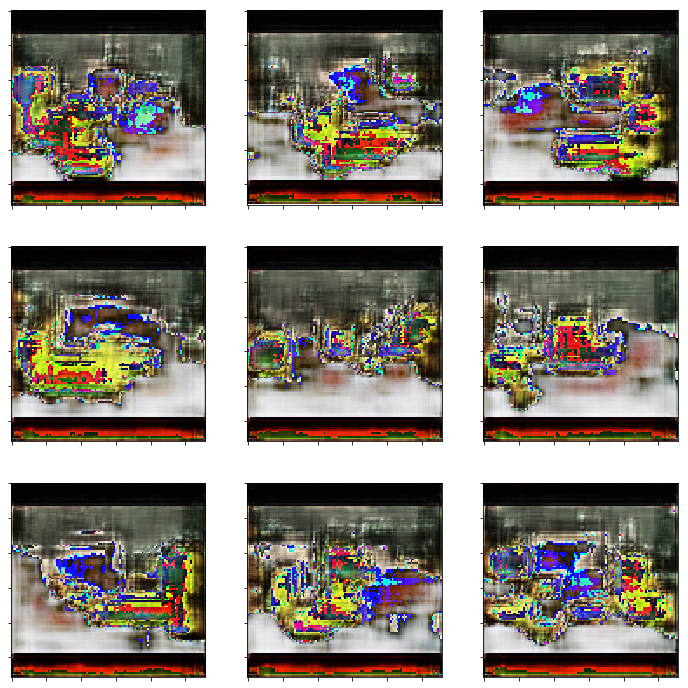

In [7]:
'''Generate images with our trained generator model'''
num_generated = 9
in_noise = np.random.rand(num_generated,100)
im = generator_model.predict(in_noise)
figure,axis = plt.subplots(3,3,figsize=(10,10))
plt.tight_layout()
for i in range(3):
    for j in range(3):
        axis[i,j].imshow(im[i*3+j])
        axis[i,j].set_yticklabels([])
        axis[i,j].set_xticklabels([])

In [ ]:
'''Save weights and models'''
discriminator_model.save_weights('dcgan_lsun_discriminator_deepmodel_weights.h5')
generator_model.save_weights('dcgan_lsun_generator_deepmodel_weights.h5')
model.save_weights('dcgan_lsun_gan_deepmodel_weights.h5')

discriminator_model.save('dcgan_lsun_discriminator_deepmodel.h5')
generator_model.save('dcgan_lsun_generator_deepmodel.h5')
model.save('dcgan_lsun_gan_deepmodel.h5')

In [6]:
'''Load weights'''
discriminator_model.load_weights('dcgan_lsun_discriminator_deepmodel_weights.h5')
generator_model.load_weights('dcgan_lsun_generator_deepmodel_weights.h5')
model.load_weights('dcgan_lsun_gan_deepmodel_weights.h5')